# Test Classifier Approach

Testing the idea to build a classifier that directly predicts actions based on observations

In [1]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt

from sbi.utils import BoxUniform
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

### Classifier without input

Data distribution over $\theta$ to sample from. 

In [2]:
dist = torch.distributions.Normal(10, 5)
thetas = torch.arange(-10, 30, 0.01)

Define a loss

In [3]:
threshold = 5.0

#loss = lambda th: (th>threshold).type(torch.float)#*0.2#*(th-threshold)  # loss when predicting th<T
#loss2 = lambda th: (th<threshold).type(torch.float)*10#*0.9#*(threshold-th) # loss when predicting th>T

def BCELoss_classweighted(weights = [10., 1.], threshold=5.0):

    def loss(theta, decision):
        """custom loss function (BCE with class weights)

        Args:
            theta (torch.Tensor): observed parameter value
            decision (int): indicates decision: 0 (below threshold) or  1(above treshold)
            threshold (float, optional): threshold for binarized decisons. Defaults to threshold.

        Returns:
            float: incurred loss
        """
        #assert decision in [0,1], "decision has to be one of 0 (below threshold) or  1(above treshold)"
        return decision * (1 - torch.gt(theta,threshold).type(torch.float)) * weights[0] + (1-decision) * torch.gt(theta,threshold).type(torch.float) * weights[1]
        if decision==0: #predicting theta<threshold
            return (theta>threshold).type(torch.float) #*0.2#*(th-threshold)
        elif decision==1: #predicting theta>threshold
            return (theta<threshold).type(torch.float)*10 #*0.9#*(threshold-th)
    
    return loss

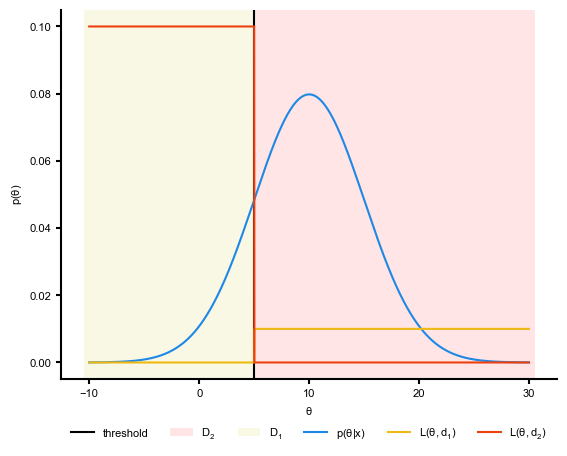

In [4]:
probs = dist.log_prob(thetas).exp()
loss = BCELoss_classweighted()

with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    plt.axvline(x=5.0, color='k', label='threshold')
    plt.axvspan(5, 30.5, facecolor='r', alpha=0.1, label=r'$D_2$')
    plt.axvspan(-10.5, 5, facecolor='y', alpha=0.1, label=r'$D_1$')

    plt.plot(thetas, probs, color='#1E88E5', label=r'$p(\theta|x)$')

    plt.plot(thetas, 0.01*loss(thetas, 0), color='#EFB913', label=r'$L(\theta, d_1)$')
    plt.plot(thetas, 0.01*loss(thetas, 1), color='#EC400E', label=r'$L(\theta, d_2)$')
    
    #plt.xticks([]); plt.yticks([])
    plt.xlabel(r'$\theta$'); plt.ylabel(r'$p(\theta)$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=6)
          
    #plt.savefig('figures/setup.pdf')
    plt.show()

Sample data 

In [5]:
N= 5000
th_train = dist.sample((N,))
y_train = (th_train>threshold).float()*2-1  #labels ±1

In [6]:
# classifier expected to converge to
loss(th_train, 0).sum() / (loss(th_train, 0) + loss(th_train, 1)).sum()

tensor(0.3546)

Define a simple classifier (only a single scalar value).

In [7]:
c = torch.nn.Parameter(torch.tensor([0.3]),requires_grad=True)

Train classifier

In [8]:
optimizer = torch.optim.SGD([c], lr=0.000001)

loss_values = []
for epoch in range(1000):
    optimizer.zero_grad()
    loss_value = -(c.log() * loss(th_train, 0).sum() + (torch.ones_like(c)-c).log() * loss(th_train,1).sum())
    loss_values.append(loss_value)
    loss_value.backward()
    optimizer.step()
    if epoch%100==0:
        print(f"{epoch}\t c = {c.item():.8f}\t L = {loss_value.item():.8f}")

0	 c = 0.30310002	 L = 7839.20214844
100	 c = 0.35434252	 L = 7757.23095703
200	 c = 0.35456723	 L = 7757.23046875
300	 c = 0.35456806	 L = 7757.22998047
400	 c = 0.35456806	 L = 7757.22998047
500	 c = 0.35456806	 L = 7757.22998047
600	 c = 0.35456806	 L = 7757.22998047
700	 c = 0.35456806	 L = 7757.22998047
800	 c = 0.35456806	 L = 7757.22998047
900	 c = 0.35456806	 L = 7757.22998047


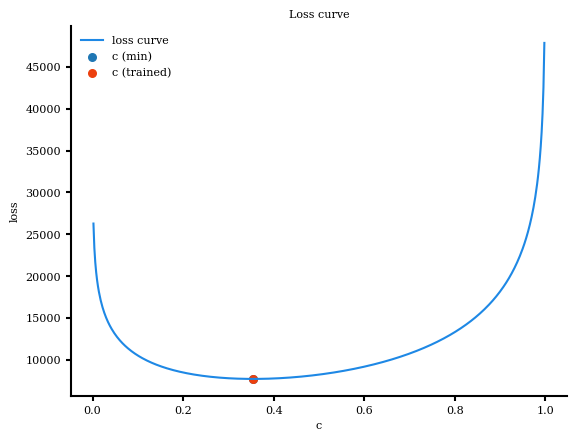

In [9]:
c_ls = torch.linspace(0, 1, 500)
result = -(torch.log(c_ls) * loss(th_train, 0).sum() + torch.log(1-c_ls) * loss(th_train, 1).sum())

with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    plt.title('Loss curve')
    plt.plot(c_ls.numpy(), result.numpy(), color='#1E88E5', label='loss curve')
    plt.xlabel('c'); plt.ylabel('loss')
    plt.scatter(c_ls[torch.argmin(result)].numpy(), torch.min(result).numpy(), s=30,label='c (min)')
    plt.scatter(c.detach().numpy(), -(torch.log(c.detach()) * loss(th_train, 0).sum() + torch.log(1-c.detach()) * loss(th_train, 1).sum()).numpy(), color='#EC400E', s=30, label='c (trained)')
    plt.legend()
    #plt.savefig('figures/loss_curve.pdf')



#### Michaels Test

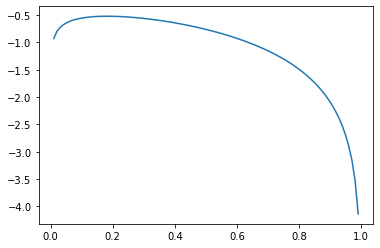

(0.1818181872367859, 0.18181818181818182)

In [10]:
# assume constant loss + threshold cutting space in half
def michael_test():
    c = torch.linspace(0, 1, 100)
    result = torch.log(c) * 0.2 + torch.log(1-c) * 0.9
    plt.plot(c.numpy(), result.numpy()); plt.show()
    return c[torch.argmax(result)].item(), 0.2 / 1.1
michael_test()

In [11]:
# check whether it converges to ratio of posterios

#### Test Integration
Try to understand what the classifier converges to

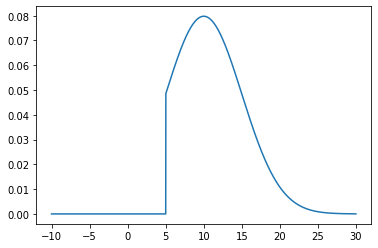

In [12]:
def loss_predict_smaller(th):
    return dist.log_prob(torch.as_tensor(th)).exp()*loss(th,0)
plt.plot(thetas, loss_predict_smaller(thetas))
i1 = loss_predict_smaller(thetas).sum()

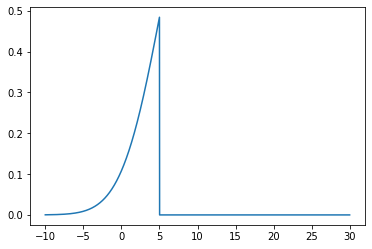

In [13]:
def loss_predict_larger(th):
    return dist.log_prob(torch.as_tensor(th)).exp()*loss(th,1)
plt.plot(thetas, loss_predict_larger(thetas))
i2 = loss_predict_larger(thetas).sum()

In [14]:
i1/(i1+i2)

tensor(0.3462)

### Classifier with input

- define 1D examples (power plant?)
    - uniform prior
    - sample from prior
    - simulator: given some theta, provides an observation -- what is theta, what is obs here?
- train classifier with prior predictives
- check convergence of classifier


Define prior and simulator

In [15]:
n = 50000 

prior = BoxUniform([0.0], [5.0,])

def simulator(theta):
    #return  10. + 0.5*(theta)*(5-theta)**4 + torch.randn(theta.shape) * 2.0 * theta
    return 50 + 0.5*theta*(5-theta)**4 + torch.randn(theta.shape) *10#* (theta+3)

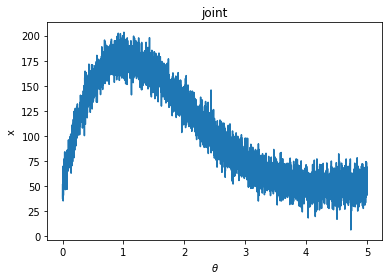

In [16]:
thetas = torch.linspace(0,5, 5000)
plt.plot(thetas, simulator(thetas)); plt.xlabel(r'$\theta$'); plt.ylabel('x'); plt.title('joint')
plt.show()

Sample data $(\theta, x) \sim p(\theta)p(x|\theta)$

In [17]:
N = 10000

th_train = prior.sample((N,))
x_train = simulator(th_train)

d_train = ((th_train>threshold).float()*2-1)#.squeeze()  #labels ±1

Define the loss

In [18]:
threshold = 2.0
bce_loss = BCELoss_classweighted(weights=[5,1],threshold=threshold)

Sample data 

In [34]:
N = 10000
th_train = prior.sample((N,))
y_train = ((th_train>threshold).float()*2-1)#.squeeze()  #labels ±1

In [35]:
# classifier expected to converge to
bce_loss(th_train, 1).sum() / (bce_loss(th_train, 0) + bce_loss(th_train, 1)).sum()

tensor(0.7738)

Define a simple NN as classifier.

In [36]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.sigmoid = nn.Sigmoid()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out) # output probability of belonging to class -1
        return out

Define custom loss

In [37]:
def BCELoss_classweighted_2(weights):
    
    def loss(prediction, target):
        prediction = torch.clamp(prediction,min=1e-7,max=1-1e-7)
        bce = - target * torch.log(prediction) * weights[0] - (1 - target) * torch.log(1 - prediction) * weights[1]
        return torch.mean(bce)
    
    return loss

Train classifier

In [38]:
clf = NeuralNet(1, 16, 1)

epochs = 1000
optimizer = torch.optim.SGD(clf.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()#BCELoss_classweighted_2(weights=[bce_loss(th_train, 0).sum(), bce_loss(th_train, 1).sum()])

loss_values = []
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = clf(th_train)
    loss_value = bce_loss(th_train, predictions)
    loss_value = criterion(predictions, (y_train+1)/2)
    #loss_value = -(predictions.log() * bce_loss(th_train,0) + \
    #    (torch.ones_like(predictions)-predictions).log() * bce_loss(th_train,1)).sum()
    with torch.no_grad():
        loss_values.append(loss_value.item())

    loss_value.backward()
    optimizer.step()
    if epoch%10==0:
        print(f"{epoch}\t c = {predictions.mean():.8f}\t L = {loss_value.item():.8f}")#, end='\r')

0	 c = 0.55473238	 L = 0.67511737
10	 c = 0.55485481	 L = 0.67505956
20	 c = 0.55497706	 L = 0.67500180
30	 c = 0.55509913	 L = 0.67494422
40	 c = 0.55522096	 L = 0.67488676
50	 c = 0.55534256	 L = 0.67482942
60	 c = 0.55546403	 L = 0.67477220
70	 c = 0.55558509	 L = 0.67471510
80	 c = 0.55570626	 L = 0.67465806
90	 c = 0.55582702	 L = 0.67460126
100	 c = 0.55594760	 L = 0.67454457
110	 c = 0.55606800	 L = 0.67448795
120	 c = 0.55618823	 L = 0.67443144
130	 c = 0.55630833	 L = 0.67437506
140	 c = 0.55642802	 L = 0.67431873
150	 c = 0.55654764	 L = 0.67426276
160	 c = 0.55666703	 L = 0.67420673
170	 c = 0.55678630	 L = 0.67415082
180	 c = 0.55690515	 L = 0.67409509
190	 c = 0.55702400	 L = 0.67403942
200	 c = 0.55714262	 L = 0.67398387
210	 c = 0.55726111	 L = 0.67392838
220	 c = 0.55737931	 L = 0.67387307
230	 c = 0.55749732	 L = 0.67381799
240	 c = 0.55761510	 L = 0.67376292
250	 c = 0.55773270	 L = 0.67370802
260	 c = 0.55785012	 L = 0.67365324
270	 c = 0.55796736	 L = 0.67359841
280

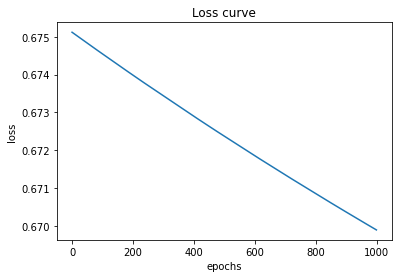

In [40]:
plt.plot(torch.arange(epochs).detach().numpy(), loss_values)
plt.title('Loss curve')
plt.ylabel('loss'); plt.xlabel('epochs')
plt.show()

In [ ]:
# is the mean prediction a good indicator for c? 

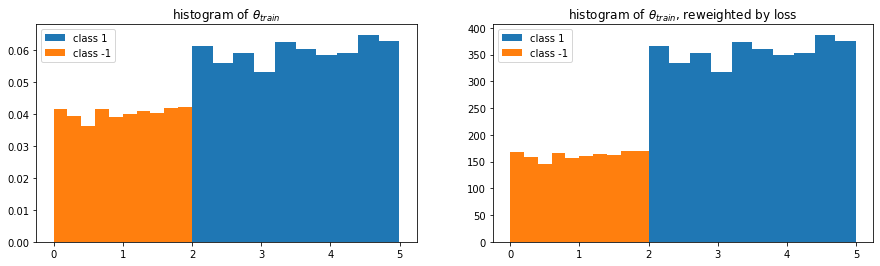

In [46]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title(r'histogram of $\theta_{train}$')
plt.hist(th_train[y_train==1].numpy(), label='class 1', weights=(torch.ones_like(th_train[y_train==1])/th_train.shape[0]).numpy())
plt.hist(th_train[y_train==-1].numpy(), label='class -1', weights=(torch.ones_like(th_train[y_train==-1])/th_train.shape[0]).numpy())
plt.legend()

plt.subplot(1,2,2)
# hist with counts corrected by loss
plt.title(r'histogram of $\theta_{train}$, reweighted by loss')
plt.hist(th_train[y_train==1].numpy(), label='class 1', weights=(torch.ones_like(th_train[y_train==1])*int(bce_loss(th_train[y_train==1], 0).sum())/th_train.shape[0]).numpy())
plt.hist(th_train[y_train==-1].numpy(), label='class -1', weights=(torch.ones_like(th_train[y_train==-1])*int(bce_loss(th_train[y_train==-1], 1).sum())/th_train.shape[0]).numpy())

plt.legend()
plt.show()

#### Compare to classical sbi